# Predicting Minecraft Server Subscription from Player Behaviour

#### Section 004, Group 13
Rama Almoustadi (26001511), Ishir Ghatpande (66960923), Micheal Pei (94453412), Stephen Wong (79445953)

## Introduction

Many online games use a hybrid business model where users can play for free but may optionally pay for premium features or subscriptions. Understanding which players are most likely to subscribe is valuable for both server administrators and game developers: it can inform marketing strategies, server design, and allocation of limited development resources.

In this project, we use data from a Minecraft research server to investigate which kinds of players are more likely to subscribe to the server. The main focus is on how demographic and play-related characteristics are associated with the probability of subscription.

### Research Question

**Can we predict whether a player will subscribe to a game-related newsletter from their demographic characteristics and in-game behaviour?** 

Here, we aim to specifically use a players age and total play time to answer the question.

We treat subscription status as the outcome (response) and use a set of player-level features as predictors. We then build and evaluate a k-nearest neighbours (KNN) classification model to answer this question.

### Dataset

We use one dataset collected from a Minecraft research server:

1. **`players.csv` (player-level data)**  
   Each row represents a unique player. Key variables include:
   - `experience` (categorical): self-reported Minecraft experience level (`"Pro"`, `"Veteran"`, `"Regular"`, `"Amateur"`).
   - `subscribe` (logical): whether the player subscribed to the server (`TRUE` / `FALSE`). This is our **response variable**.
   - `hashedEmail` (character): anonymized player identifier used to link with the sessions dataset.
   - `played_hours` (numeric): total hours the player spent on the server.
   - `name` (character): player’s first name (not used in the analysis).
   - `gender` (categorical): player’s gender.
   - `Age` (numeric): player’s age in years.

   The dataset contains **196 observations** and **7 variables**.

In the following sections, we describe our methods, present exploratory summaries and visualizations, fit a KNN classifier, and interpret its performance in the context of our research question.


## Methods & Results

We begin by loading, cleaning, and summarizing the dataset

In [7]:
# loading packages and dataset
library(tidyverse)
library(tidymodels)

players_url <- "https://raw.githubusercontent.com/ishirGhatpande/Individual-Project-Planning/refs/heads/main/players.csv"
players <- read_csv(players_url)
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


### Cleaning up the data
To clean up the `players.csv` dataset, we firstly rename the age column to make it cohesive with other column names. We convert subscribe into a factor for its eventual use in our KNN analysis, and change the factor names from TRUE/FALSE to Subscribed/Not Subscribed make them more descriptive and intuitive to work with. 

In [8]:
#cleaning data
players <- players |>
    rename(age = Age) |> 
    select(subscribe, played_hours, age) |>
    mutate(subscribe = as_factor(subscribe)) |>
    mutate(subscribe = fct_recode(subscribe, "Subscribed" = "TRUE", "Not Subscribed" = "FALSE")) |>
    na.omit() 
head(players)

subscribe,played_hours,age
<fct>,<dbl>,<dbl>
Subscribed,30.3,9
Subscribed,3.8,17
Not Subscribed,0.0,17
Subscribed,0.7,21
Subscribed,0.1,21
Subscribed,0.0,17


### Summary statistics
Here we calculate and report main summary values of our interested variables from the `players.csv` data set

In [4]:
summary(players)

#Find percentage of subscribed and not subscribed
num_obs <- nrow(players)
players|>
group_by(subscribe)|>
summarize(
    count = n(),
    percentage = n()/num_obs *100)

  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

subscribe,count,percentage
<lgl>,<int>,<dbl>
FALSE,52,26.53061
TRUE,144,73.46939


#### Table 1: Summary Statistics of Tidy players.csv Dataset (196 Observations and 3 Variables)
| Variable | Variable Type | Description|# of Subscribed|# of Not Subscribed |Percentage of Subscribed|Percentage of Not Subscribed|Minimum| Median|Mean|Maximum|
| -------- | ------- |---|---|---|---|---|---|---|---|---|
| subscribe | Factor|Player's Subscription Status|52|144|73.47%|26.53%| N/A| N/A|N/A|N/A|
| played_hours| Double |Player's total hours played|N/A|N/A|N/A|N/A| 0.00 |0.10|5.85|223.10|
| age | Double |Player's Age|N/A|N/A|N/A|N/A|9.00|19.00|21.14|58.00|

The dataset contains 196 observations across three variables. For the factoral variable `subscribe`, we calculate the percentage of players currently subscribed and those who aren't. We found that the majority of players, 73.47% (144 players) are subscribed, while 26.53% (52 players) are not. \
The two double variables are played_hours and age. The `played_hours` variable is the total amount of a player's played hours; it ranged from a minimum of 0.00 to a maximum of 223.10 hours, with a mean of 5.85 hours and a median of 0.10 hours, suggesting the data is skewed to the right. The age variable is a player's age, ranging from a minimum of 9.00 to a maximum of 58.00 years, with a mean of 21.14 years and a median of 19.00 years.


### Exploratory Data Analysis

Before creating our predictive model, we visualize our two variables of interest, `age` and `played_hours`, and inspect how they relate to subscription status.

We create figures based on the relationship between both variables first, and then separate them and visualize any trends that might exist based on subscription status of players.

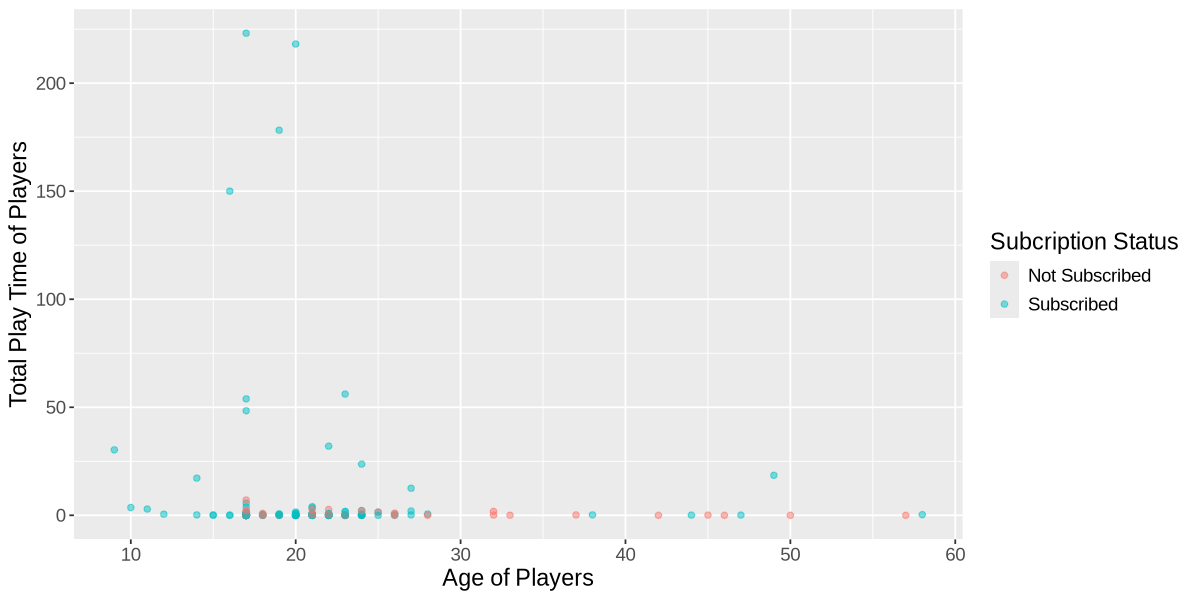

In [43]:
#visualizing both variables in a scatterplot
age_hours <- players |>
    ggplot(aes(x = age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.5) +
    labs(x = "Age of Players", y = "Total Play Time of Players", color = "Subcription Status") +
    theme(text = element_text(size = 14)) 
age_hours

#### Figure 1: Scatterplot of total play time of players against their ages
From this visualization we can gather that: 
- Players across all ages are subscribed and unsubscribed
- The players with longer play time are likely to be subscribed
- Play times above ~25h are found most of the time in younger players
- There are many people with a play time of 0 total hours, some of then subscribed and some not

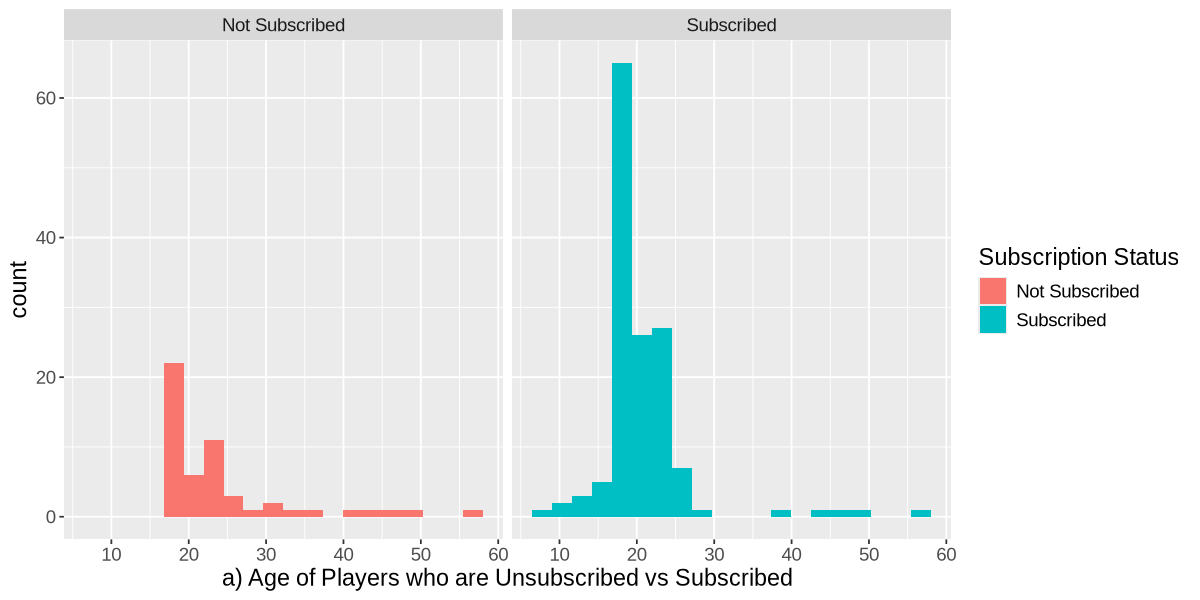

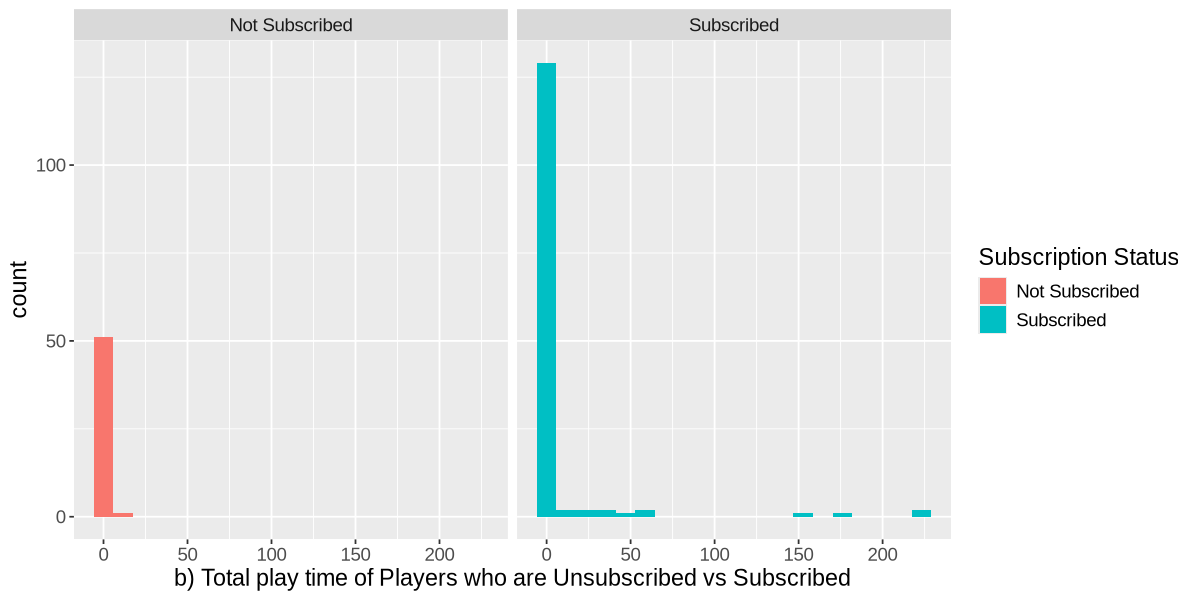

In [44]:
#visualizing each variables' spread based on subscription status

age_subscription <- players |>
    ggplot(aes(x = age, fill = subscribe)) +
    geom_histogram(bins = 20) +
    facet_grid(cols = vars(subscribe)) +
    labs(x = "a) Age of Players who are Unsubscribed vs Subscribed", fill = "Subscription Status") +
    theme(text = element_text(size = 14))
age_subscription

hours_subscription <- players |>
    ggplot(aes(x = played_hours, fill = subscribe)) +
    geom_histogram(bins = 20) +
    facet_grid(cols = vars(subscribe)) +
    labs(x = "b) Total play time of Players who are Unsubscribed vs Subscribed", fill = "Subscription Status") +
    theme(text = element_text(size = 14))
hours_subscription

#### Figure 2: a) Distributions of age of all players separated by subscription status b) Distributions of the total play time of players separated by subscription status
From these distributions:
- The age and play time spread of subscribed players is larger than unsubscribed
- There are no recorded unsubscribed players below the age of ~17, which interestingly is also the age that the most amount of subscribed players fall into
- All unsubscribed players have a relatively low play time compared to those subscribed, but the largest group of subscribed players also falls into 0 hours

### K-Nearest Neighbours Classification

We now build a KNN classifier using predictor variables: `age` and `played_hours`. Our response variable is `subscribe`.

#### Preprocessing
KNN relies on distances, so numeric variables are **standardized**.

#### Train/Test Split
We use:
- 75% training data  
- 25% testing data  
- Stratified on `subscribe`

We initially split the data 80% training and 20% testing, but due to the small size of the dataset and the unevenness of proportion of subscribed and unsubscribed players, the resulting test set was too small. So, we decided to give the test set a larger share of the data, but still keeping in mind that the model needs to be trained with enough data to perform as accurately as possible.

#### Cross-Validation
We tune the model to identify the optimal K value using 5-fold cross-validation.

When choosing the range of k-values (neighbours) to tune the model with, we first chose to use k values from 1 to 100 by 5, but found the resulting accuracy estimates to plateau past k = 30. From this, we decided to try k values 1 to 35 by 1 to get a closer look at the way the accuracy changes with growing k and eliminate the redundancy of unchanging accuracy.

The K that achieved the highest cross-validated accuracy was selected and used to re-train and finalize the model. This final model was evaluated on the testing set using last_fit(), and a confusion matrix was generated to assess prediction performance.

In [52]:
#performing k-nn classification
set.seed(12) #setting the seed allows code to be fully reproducible

#splitting the data, 75% to training set and 25% to testing set
players_split <- initial_split(players, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test  <- testing(players_split)

#creating the recipe + preprocessing steps
knn_recipe <- recipe(subscribe ~ age + played_hours, data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

#model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#tuning the model to find the best k value, started out from 1 to 35 by 1
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)
k_vals <- tibble(neighbors = seq(from = 1, to = 35, by = 1))

players_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics() 

players_results <- players_fit |> filter(.metric == "accuracy")
head(players_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5182430,5,0.04821584,Preprocessor1_Model01
2,accuracy,binary,0.5251396,5,0.04867110,Preprocessor1_Model02
3,accuracy,binary,0.5739245,5,0.05674549,Preprocessor1_Model03
4,accuracy,binary,0.5527258,5,0.03682729,Preprocessor1_Model04
5,accuracy,binary,0.6486371,5,0.04644932,Preprocessor1_Model05
6,accuracy,binary,0.6553038,5,0.04984280,Preprocessor1_Model06


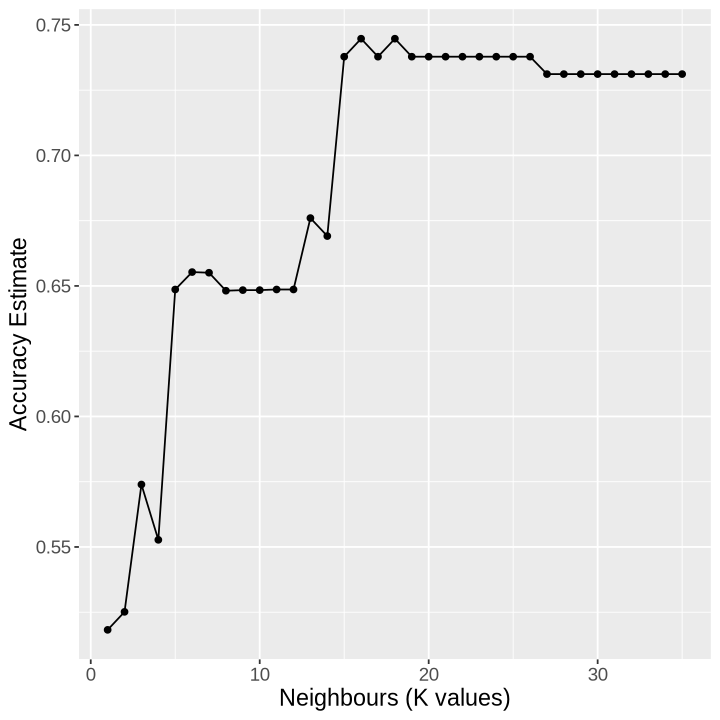

In [53]:
#visualizing the accuracy vs. k
options(repr.plot.height = 6, repr.plot.width = 6)
accuracy_vs_k <- players_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours (K values)", y = "Accuracy Estimate") +
    theme(text = element_text(size = 14))
accuracy_vs_k

#### Figure 3: Accuracy estimates based on number of neighbours

In [55]:
#identifying the best k
best_k <- players_results |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

#the cross validation accuracy estimate of k = 17
best_k_accuracy <- players_results |>
    filter(neighbors == 16) |>
    pull(mean)
best_k_accuracy

[1] 16

[1] 0.7447126

In [57]:
#retraining model based on best k value
knn_recipe <- recipe(subscribe ~ age + played_hours, data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

players_fit <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_train)

When calculating precision and recall, it has to be specified which label of our response variable is the positive one. We chose to specify that "Subscribe" is the positive variable, because in application of our analysis we think the developers of the server would benefit from knowing the audience that is currently subscribed, so that they can work to keep them subscribed. This could mean catering the content of the newsletter to the respective subscribed demographic, or altering 

In [58]:
#calculating accuracy of the model on test data
accuracy <- players_test_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
accuracy

#calculating precision
players_test_predictions|> pull(subscribe) |> levels()
precision <- players_test_predictions |> 
    precision(truth = subscribe, estimate = .pred_class, event_level = "second")
precision

#calculating recall
recall <- players_test_predictions |> 
    recall(truth = subscribe, estimate = .pred_class, event_level = "second")
recall

#confusion matrix 
conf_mat <- players_test_predictions |> 
    conf_mat(truth = subscribe, estimate = .pred_class)
conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6938776


[1] "Not Subscribed" "Subscribed"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.744186


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.8888889


                Truth
Prediction       Not Subscribed Subscribed
  Not Subscribed              2          4
  Subscribed                 11         32

#### Table 2: Confusion Matrix

## Discussion 


Our analysis shows that age and played_hours have moderate predictive ability for the subscription behavior of the players. The best KNN model was found at k = 21. After we assign this value to test data, we found that accuracy is almost 0.70, precision is almost 0.72, and recall is almost 0.97. This suggests that the model have a good ability to identify the players who subscribe, but less confident in determining players who do not subscribe. In other words, most actual subscribers are successfully detected, but some non-subscribers are incorrectly predicted as subscribers(testing results is showing on the tibble above)